In [1]:
# Append 'src' directory to import modules from notebooks directory
#################################
import os,sys
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)
##################################

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 150)

import time
import os 
from src.PatchMatch import PatchMatchOrig
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [3]:
# cnn = models.vgg19_bn(pretrained=True).features
cnn = models.vgg19(pretrained=True).features
# cnn = models.vgg16(pretrained=True).features

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self,name, layer):
        self.add_module(name, layer)
    
    def forward(self,x):
        list = []
        for module in self._modules:
            x = self._modules[module](x)
            list.append(x)
        return list

In [23]:
model_t = FeatureExtractor()  # the new Feature extractor module network
i = 1
conv_counter = 1
relu_counter = 1
pool_counter = 1
batn_counter = 1

block_counter = 1

for layer in list(cnn):
    
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_"+str(conv_counter)
        conv_counter +=1
        model_t.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_"+str(relu_counter)
        relu_counter +=1
        model_t.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        pool_counter = bn_counter = relu_counter = conv_counter= 1
        block_counter +=1
        model_t.add_layer(name, nn.AvgPool2d((2,2)))  # ***
        
    if isinstance(layer, nn.BatchNorm2d):
        name = "batn_" + str(block_counter) + "_"+str(batn_counter)
        batn_counter +=1
#         model_t.add_layer(name, layer)  # ***


In [107]:
scale, tensorize, normalize = transforms.Scale((224,224)),transforms.ToTensor(),\
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    
loader = transforms.Compose([
    scale,tensorize,normalize
])
#ok

def image_loader(img_path,flip=False):
    
    ava = Image.open(img_path).convert("RGB")
    if flip:
        ava = ava.transpose(Image.FLIP_LEFT_RIGHT)
            
#     b, g, r = ava.split()
#     ava = Image.merge("RGB", (r, g, b))

    
    image = loader(ava)
    image = Variable(image.unsqueeze(0))

    return image


# t = Variable(torch.from_numpy(np.random.random(size=(1,3,224,224))).float())
ava = image_loader('./cat_left.jpg',flip=False).float()
mona = image_loader('./cat_white.jpg').float()

ava.data.size()
np.unique(ava.data.numpy())

array([-2.10077929, -2.0836544 , -2.06652975, -2.04940486, -2.03228021,
       -2.01515555, -1.99803066, -1.98090601, -1.96378124, -1.94665647,
       -1.93067217, -1.92953169, -1.91316521, -1.91240692, -1.89565825,
       -1.89528215, -1.87815738, -1.87815118, -1.86103272, -1.86064422,
       -1.84390795, -1.84313726, -1.82678318, -1.82563019, -1.80965841,
       -1.80812323, -1.79253364, -1.79061615, -1.77540886, -1.7731092 ,
       -1.75828421, -1.75560224, -1.74115944, -1.73809516, -1.72403467,
       -1.72058821, -1.71729851, -1.70690989, -1.70308125, -1.69986928,
       -1.68978512, -1.68557417, -1.68244004, -1.67266035, -1.66806722,
       -1.66501093, -1.6555357 , -1.65056014, -1.6475817 , -1.63841093,
       -1.63305318, -1.63015246, -1.62128615, -1.61554623, -1.61272335,
       -1.60416138, -1.59803915, -1.59529412, -1.58703661, -1.58053219,
       -1.57786489, -1.56991184, -1.56302524, -1.56043577, -1.55278718,
       -1.54551816, -1.54300654, -1.53566241, -1.5280112 , -1.52

In [108]:
model_t

FeatureExtractor (
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU (inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU (inplace)
  (pool_1): AvgPool2d (size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False, count_include_pad=True)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU (inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU (inplace)
  (pool_2): AvgPool2d (size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False, count_include_pad=True)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU (inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU (inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU (inplace)
  (c

torch.Size([512, 14, 14])
torch.Size([512, 1, 14, 14])


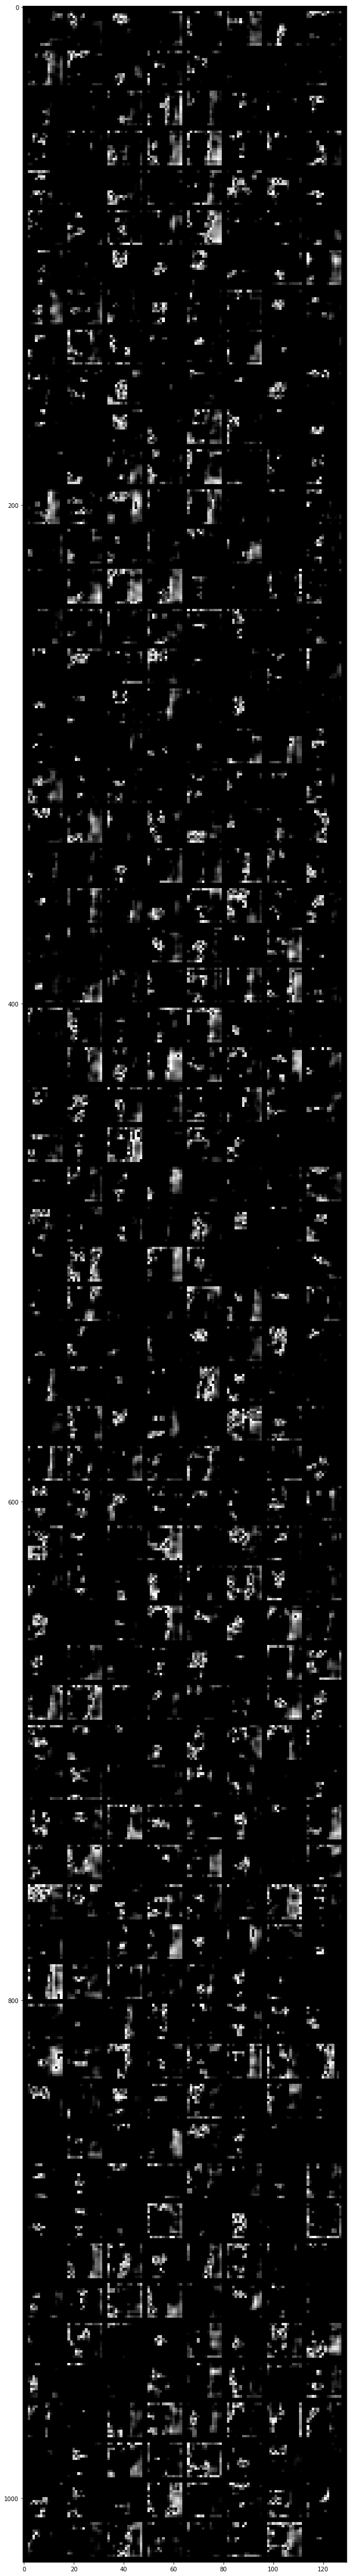

In [109]:
squeezed_ava = torch.squeeze(model_t(ava)[-7].data)
print(squeezed_ava.size())
reshaped_ava = squeezed_ava.view(-1,1,squeezed_ava.size()[1],squeezed_ava.size()[2])
print(reshaped_ava.size())

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

show(make_grid(reshaped_ava))

# for i in range(512):
#     plt.imshow(squeezed_ava[i].numpy()*255,cmap='gray')
#     plt.show()

torch.Size([512, 14, 14])


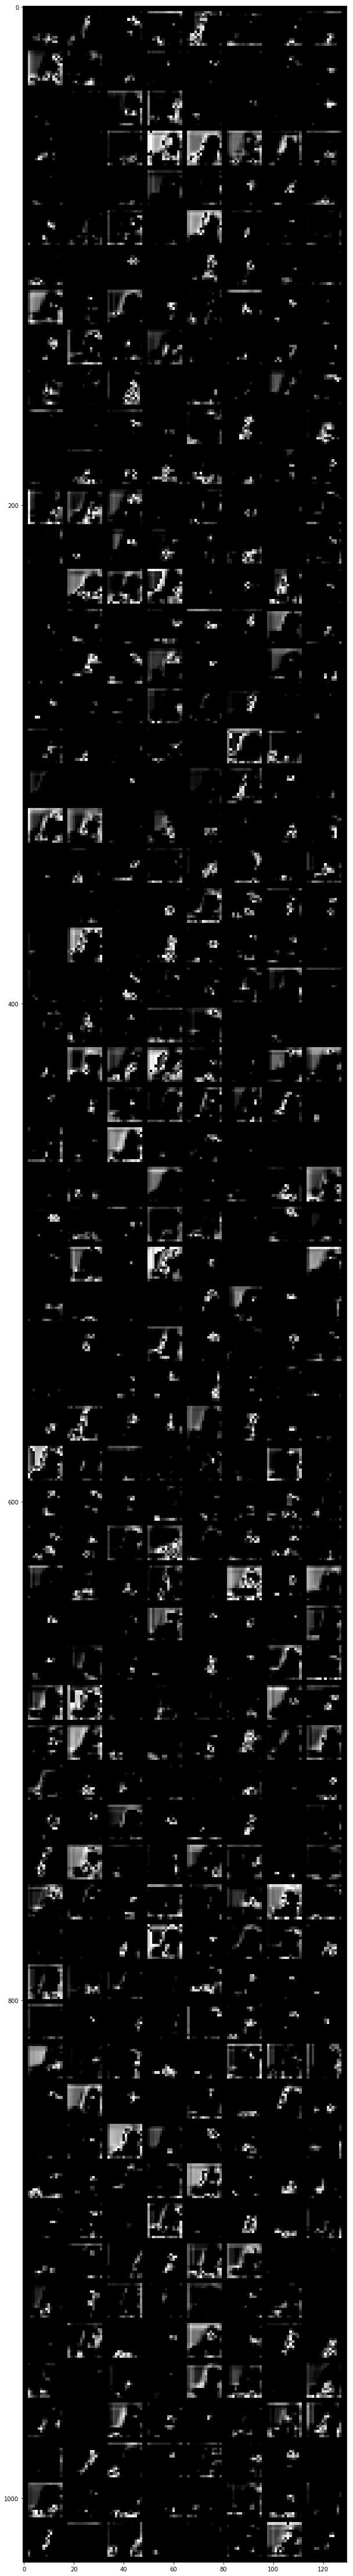

In [110]:
squeezed_mona = torch.squeeze(model_t(mona)[-7].data)
print(squeezed_mona.size())
reshaped_mona = squeezed_mona.view(-1,1,squeezed_mona.size()[1],squeezed_mona.size()[2])

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(make_grid(reshaped_mona))

(14, 14, 512)


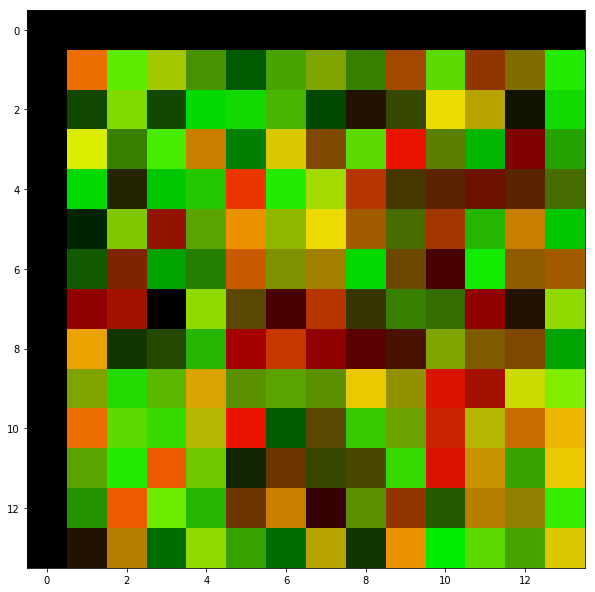

In [ ]:
ava_arr = squeezed_ava.numpy().transpose(1,2,0)
mona_arr = squeezed_mona.numpy().transpose(1,2,0)
print(ava_arr.shape)

pm = PatchMatchOrig(ava_arr,mona_arr, 5)
plt.imshow(pm.visualize()) # visualise a random nnf

In [ ]:
pm.propagate(iters=5)

done iteration


In [ ]:
plt.imshow(pm.visualize())

In [100]:
ava_arr.shape

(14, 14, 512)

In [101]:
ava_big = np.squeeze(ava.data.numpy()).transpose(1,2,0)
mona_big = np.squeeze(mona.data.numpy()).transpose(1,2,0)

In [102]:
ava_big.shape
mona_big.shape

(224, 224, 3)

In [103]:
final_img = np.zeros_like(ava_big)
scale = 16

for i in range(14):
    for j in range(14):
        x,y = pm.nnf[i,j]
        if final_img[scale*i:scale*(i+1),scale*j:scale*(j+1)].shape == mona_big[scale*y:scale*(y+1),scale*x:scale*(x+1)].shape:
            final_img[scale*i:scale*(i+1),scale*j:scale*(j+1)] = mona_big[scale*y:scale*(y+1),scale*x:scale*(x+1)]
            print("done")
#         plt.imshow(ava_big[7*x:7*x+7,7*y:7*y+7])
#         plt.show()

final_img[:,:,0] = (final_img[:,:,0]*.228 + .485)
final_img[:,:,1] = (final_img[:,:,1]*.224 + .456)
final_img[:,:,2] = (final_img[:,:,2]*.225 + .406)


# transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]
        

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


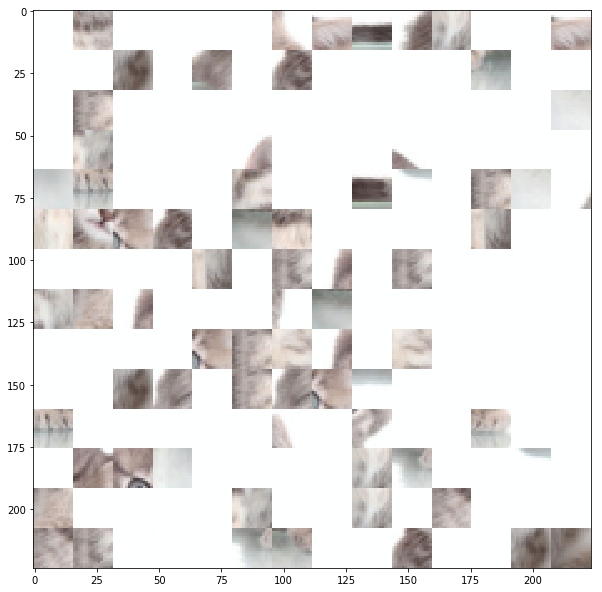

In [105]:
plt.imshow(final_img[:,:,::])

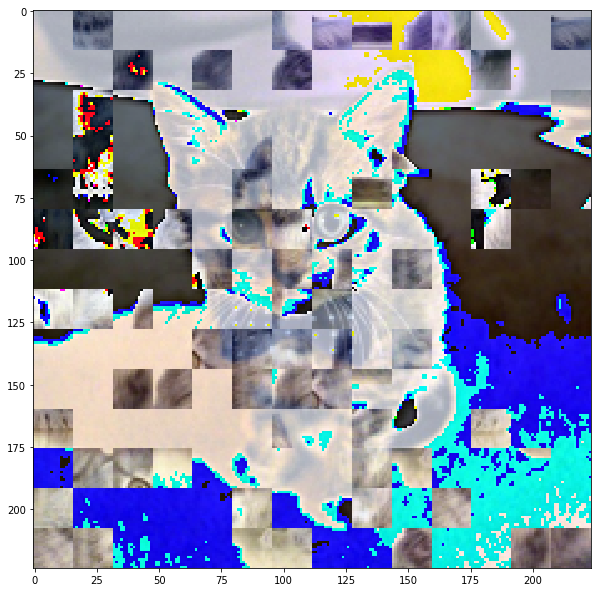

In [106]:
plt.imshow(ava_big/6+final_img[:,:,::-1])

In [ ]:
plt.imshow(mona_big)
plt.show()
plt.imshow(ava_big)
plt.show()
# plt.imshow(final_img[:,:,::-1]/2 +mona_big/2)
# plt.show()

In [ ]:
mona_big.shape